## Scrape Wikinews data with more information
From the "Politics and Conflict" section of the Wikinews 

In [7]:
import requests
from bs4 import BeautifulSoup
import codecs
import csv
import os
import re
from tqdm.notebook import tqdm
import time
import pandas as pd
from newspaper import Article
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Xiqing\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
url = 'https://en.wikinews.org/wiki/Category:Politics_and_conflicts'

In [ ]:
# initilize the home page
response = requests.get(url)
contents = response.text
soup = BeautifulSoup(contents, 'html.parser')
current_page = soup.find(id = "mw-pages")
# regexp of "next page" url
reg = r"<a href=\"\/w\/index\.php\?title=Category:Politics_and_conflicts&amp;(pagefrom=[^#]*#mw-pages)\" title=\"Category:Politics and conflicts\">next page</a>"
next_page = re.findall(reg, str(current_page))

In [3]:
wiki_news_path = '/Users/xiqing/Documents/OneDrive/文档/GitHub/DS_project/Final/wiki.csv'

In [ ]:
# write csv header
with codecs.open(wiki_news_path,'w', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['title','scrape_at','url', 'pub_date', 'content','category','keyword','summary'])
# collect news
while next_page:
  soup = BeautifulSoup(contents, 'html.parser')
  current_page = soup.find(id = "mw-pages")
  news_row = []
  filtered = current_page.findAll(name='a',attrs={"href":re.compile(r'^(\/wiki\/[\s\S]*)')}) #'^(/wiki/[MNOPRSTUVW])')})
  if filtered:
      for i in filtered:
        # news title and url
        title = i.get_text()
        title_url = 'https://en.wikinews.org'+i['href']
        news_page = BeautifulSoup(requests.get(title_url).text, 'html.parser').find(class_="mw-parser-output")
        # publish date
        pub_date = [i.get('title') for i in news_page.findAll(name='span',attrs={"id":re.compile(r'publishDate')})]
        pub_date = ''.join(pub_date)
        # scrape time
        scrape_at = time.strftime("%Y.%m.%d %H:%M:%S", time.localtime())
        # content
        content = [i.get_text() for i in news_page.findAll(name='p')[1:]]
        content = ' '.join(content)
        # category word
        cat_word = BeautifulSoup(requests.get(title_url).text, 'html.parser').find(class_="catlinks")
        category =[i.get_text() for i in cat_word.findAll(name='a',attrs={"href":re.compile(r'(\/wiki\/Category:)\b(?!Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[\s\S]*[^"]')})]
        category = ','.join(category)
        # use newspaper3k and nlp to generate info about news
        article = Article(title_url)
        article.download()
        article.html
        article.parse()
        article.nlp()
        # content = article.text
        # keyword
        key_word = article.keywords
        # summary
        summary = article.summary
        news_row.append([title, scrape_at, title_url, pub_date, content, category, key_word, summary])
      with codecs.open(wiki_news_path,'a+', encoding='utf-8') as f:
        writer = csv.writer(f)
        for data in news_row:
            writer.writerow(data)
  next_page = re.findall(reg, str(current_page))
  if next_page:
    response = requests.get("https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&" + next_page[0])
    contents = response.text

In [5]:
# read csv
df = pd.read_csv(wiki_news_path)
#df=df.drop(labels=range(0,10),axis=0)
#df=df.reset_index(drop=True)

In [ ]:
# add type
df['type']='political'
# add domain
df['domain']='wikinews.org'
# add domain
df['author']='wikinews'
# save to csv
df.to_csv(wiki_news_path, header=None)

## Load Wikinews csv file

We have scraped and created a wikinews csv file which has header "id, title, scrape_at, url, pub_date, content, category, keyword, summary, type, domain, author". 


Just like before loading fakenews, we load wiki.csv to table `wikinews`:

```
CREATE TABLE wiknews
(
	id INTEGER,title TEXT,scrape_at timestamp,url TEXT,pub_date DATE,
	content TEXT,category TEXT,keywords TEXT,
	summary TEXT,type TEXT,domain TEXT,author TEXT
);
```

In [3]:
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

In [1]:
rootuser = 'admin'
your_pwd = '19980903'
path_input = wiki_news_path # Input data file path
name_Database = "m2"
myschema = 'wikinews'
name_table = myschema+'.news'

In [5]:
# create schema
con = psycopg2.connect(database=name_Database,user='admin',password=your_pwd,host='127.0.0.1',port='5432')
cur = con.cursor()
cur.execute("create schema " +myschema+";") 
#cur.execute("GRANT ALL PRIVILEGES ON SCHEMA " +myschema+ " TO GROUP xq;") 
con.commit()

In [13]:
con = psycopg2.connect(database=name_Database,user='admin',password=your_pwd,host='127.0.0.1',port='5432')
cur = con.cursor()
# Create a table 'news'
cur.execute('DROP TABLE IF EXISTS '+name_table+';')
cur.execute("CREATE TABLE "+name_table+"(id TEXT,title TEXT,scrape_at timestamp,url TEXT,pub_date TEXT, content TEXT,category TEXT,keywords TEXT,summary TEXT,type TEXT,domain TEXT,author TEXT);")
# Copy data from csv file to database
cur.execute("COPY "+name_table+" FROM \'"+path_input+"\' DELIMITER ',' CSV HEADER;")
# Delete news without 'id' attribute
cur.execute('DELETE FROM '+name_table+' WHERE id IS NULL')
# Delete text in 'id' attribute
cur.execute("DELETE FROM "+name_table+" WHERE id ~* '^[a-zA-Z]|\d*\.\d*'")
# Set INTEGER for id
cur.execute("ALTER TABLE "+name_table+" ALTER COLUMN id TYPE integer USING id::integer")
# Set DATE for pub_date
cur.execute("delete FROM "+name_table+" WHERE CHAR_LENGTH(pub_date)>10")
cur.execute("ALTER TABLE "+name_table+" ALTER COLUMN pub_date TYPE DATE USING pub_date::DATE") 
con.commit()

## Schema design

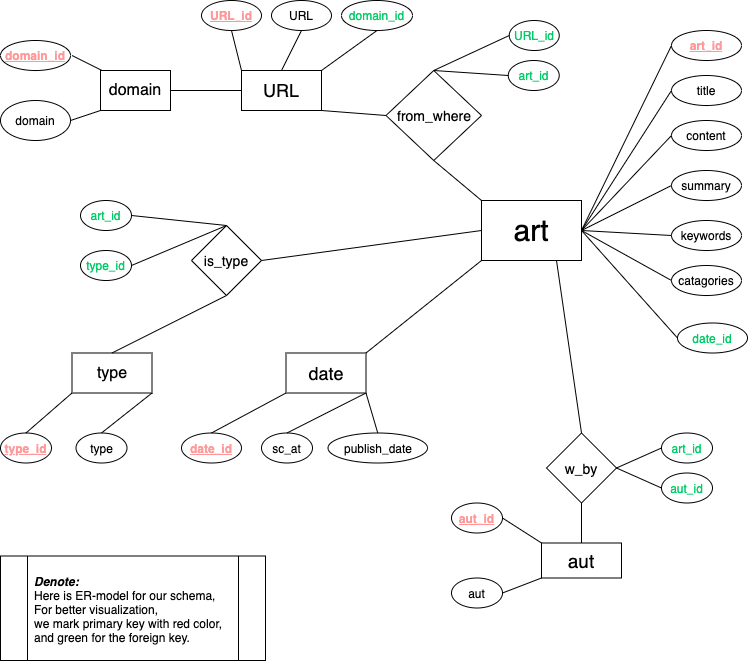

In [4]:
# Connect to pSQL
con = psycopg2.connect(database=name_Database,user='admin',password=your_pwd,host='127.0.0.1',port='5432')
cur = con.cursor()

### **1.1** Creat table `domain`

In [14]:
# create table domain
cur.execute("DROP TABLE IF EXISTS wikinews.domain")
cur.execute("SELECT id,domain INTO wikinews.domain FROM "+name_table+";")
# delete duplicate domains
cur.execute('DELETE FROM wikinews.domain d WHERE d.id NOT IN (SELECT MIN(id) FROM wikinews.domain GROUP BY domain)')
# drop id
cur.execute('ALTER TABLE wikinews.domain DROP COLUMN id')
# generate domain_id
cur.execute('ALTER TABLE wikinews.domain ADD COLUMN d_id SERIAL UNIQUE')
# set domain as Primary key (PK)
cur.execute('ALTER TABLE wikinews.domain ADD PRIMARY KEY(d_id)')
con.commit()

### **1.2** Creat table `URL`

In [15]:
# create table URL
cur.execute("DROP TABLE IF EXISTS wikinews.URL")
cur.execute("SELECT id,URL,domain INTO wikinews.URL FROM "+name_table+";")
# rename id to url_id
cur.execute('ALTER TABLE wikinews.URL RENAME COLUMN id TO url_id')
# insert domain_id
cur.execute('ALTER TABLE wikinews.URL ADD column d_id integer')
cur.execute('UPDATE wikinews.URL SET d_id = wikinews.domain.d_id FROM wikinews.domain WHERE wikinews.URL.domain=wikinews.domain.domain')
cur.execute('ALTER TABLE wikinews.URL DROP COLUMN domain')
# set url_id as PK
cur.execute('ALTER TABLE wikinews.URL ADD PRIMARY KEY (url_id)')
con.commit()

### **1.3** Creat table `date`

In [16]:
# create table date
cur.execute("DROP TABLE IF EXISTS wikinews.date")
cur.execute("SELECT id,scrape_at,pub_date INTO wikinews.date FROM "+name_table+";")
# delete duplicate date
cur.execute('DELETE FROM wikinews.date d WHERE d.id NOT IN (SELECT MIN(id) FROM wikinews.date GROUP BY scrape_at,pub_date)')
# add date_id
cur.execute('ALTER TABLE wikinews.date DROP COLUMN id')
cur.execute('CREATE SEQUENCE wikinews.date_id')
cur.execute("ALTER TABLE wikinews.date ADD COLUMN date_id integer NOT NULL DEFAULT NEXTVAL('wikinews.date_id')")
cur.execute('ALTER SEQUENCE wikinews.date_id OWNED BY wikinews.date.date_id')
# set date_id as PK
cur.execute('ALTER TABLE wikinews.date ADD PRIMARY KEY (date_id)')
con.commit()

### **1.4** Creat table `article`

In [17]:
# create table article
cur.execute("DROP TABLE IF EXISTS wikinews.article")
cur.execute("SELECT id,title,summary,content,scrape_at,pub_date,keywords,category INTO wikinews.article FROM "+name_table+";")
# insert date_id
cur.execute('ALTER TABLE wikinews.article ADD column date_id integer')
cur.execute('UPDATE wikinews.article SET date_id = date.date_id FROM wikinews.date WHERE article.scrape_at=date.scrape_at AND article.pub_date=date.pub_date')
cur.execute('ALTER TABLE wikinews.article DROP COLUMN scrape_at, DROP COLUMN pub_date')
# set id as PK
cur.execute('ALTER TABLE wikinews.article ADD PRIMARY KEY (id)')
# set date_id as foreign key (FK)
cur.execute('ALTER TABLE wikinews.article ADD CONSTRAINT fk_date FOREIGN KEY (date_id) REFERENCES wikinews.date(date_id)')
con.commit()

### **1.5** Creat table `from_where`

In [18]:
# create table from_where
cur.execute("DROP TABLE IF EXISTS wikinews.from_where")
cur.execute("SELECT id INTO wikinews.from_where FROM "+name_table+";")
cur.execute('ALTER TABLE wikinews.from_where ADD COLUMN url_id integer')
cur.execute('UPDATE wikinews.from_where SET url_id=id;')
# set FK
cur.execute('ALTER TABLE wikinews.from_where ADD CONSTRAINT fk_fromurlid FOREIGN KEY (url_id) REFERENCES wikinews.URL(url_id)')
cur.execute('ALTER TABLE wikinews.from_where ADD CONSTRAINT fk_fromartid FOREIGN KEY (id) REFERENCES wikinews.article(id)')
con.commit()

### **1.6** Creat table `type`

In [19]:
# create table type
cur.execute("DROP TABLE IF EXISTS wikinews.type")
cur.execute("SELECT id,type into wikinews.type from "+name_table+";")
# delete duplicate type
cur.execute('DELETE FROM wikinews.type t WHERE t.id NOT IN (SELECT MIN(id) FROM wikinews.type GROUP BY type)')
# add type_id
cur.execute('ALTER TABLE wikinews.type DROP COLUMN id')
cur.execute('CREATE SEQUENCE wikinews.type_id')
cur.execute("ALTER TABLE wikinews.type ADD COLUMN type_id integer NOT NULL DEFAULT NEXTVAL('wikinews.type_id')")
cur.execute('ALTER SEQUENCE wikinews.type_id OWNED BY wikinews.type.type_id')
# set type_id as PK
cur.execute('ALTER TABLE wikinews.type ADD PRIMARY KEY (type_id)')
con.commit()

### **1.7** Creat table `aut`

In [20]:
# create table aut(author)
cur.execute("DROP TABLE IF EXISTS wikinews.aut")
cur.execute("SELECT id,author INTO wikinews.aut FROM "+name_table+";")
# delete dup authors
cur.execute('DELETE FROM wikinews.aut a WHERE a.id NOT IN (SELECT MIN(id) FROM wikinews.aut GROUP BY author)')
# drop id
cur.execute('ALTER TABLE wikinews.aut DROP COLUMN id')
# gen aut_id
cur.execute('ALTER TABLE wikinews.aut add COLUMN aut_id SERIAL UNIQUE')
# set domain as PK
cur.execute('ALTER TABLE wikinews.aut ADD PRIMARY KEY(aut_id)')
con.commit()

### **1.8** Creat table `w_by`

In [21]:
# create table from_where
cur.execute("DROP TABLE IF EXISTS wikinews.w_by")
cur.execute("SELECT id,author INTO wikinews.w_by FROM "+name_table+";")
# insert aut_id
cur.execute('ALTER TABLE wikinews.w_by ADD COLUMN aut_id integer')
cur.execute('UPDATE wikinews.w_by SET aut_id = wikinews.aut.aut_id FROM wikinews.aut WHERE wikinews.aut.author=wikinews.w_by.author')
cur.execute('ALTER TABLE wikinews.w_by DROP COLUMN author')
# set FK
cur.execute('ALTER TABLE wikinews.w_by ADD CONSTRAINT fk_autid FOREIGN KEY (aut_id) REFERENCES wikinews.aut(aut_id)')
cur.execute('ALTER TABLE wikinews.w_by ADD CONSTRAINT fk_artautid FOREIGN KEY (id) REFERENCES wikinews.article(id)')
con.commit()

### **1.9** Creat table `is_type`

In [22]:
# create table from_where
cur.execute("DROP TABLE IF EXISTS wikinews.is_type")
cur.execute("SELECT id,type INTO wikinews.is_type FROM "+name_table+";")
# insert type_id
cur.execute('ALTER TABLE wikinews.is_type ADD COLUMN type_id integer')
cur.execute('UPDATE wikinews.is_type SET type_id=wikinews.type.type_id FROM wikinews.type WHERE wikinews.is_type.type=wikinews.type.type')
cur.execute('ALTER TABLE wikinews.is_type DROP COLUMN type')
# set FK
cur.execute('ALTER TABLE wikinews.is_type ADD CONSTRAINT fk_typeid FOREIGN KEY (type_id) REFERENCES wikinews.type(type_id)')
cur.execute('ALTER TABLE wikinews.is_type ADD CONSTRAINT fk_arttypeid FOREIGN KEY (id) REFERENCES wikinews.article(id)')
con.commit()

In [23]:
con.close()

## Basic statistics of Wikinews

In [9]:
# Connect to pSQL
con = psycopg2.connect(database=name_Database,user='admin',password=your_pwd,host='127.0.0.1',port='5432')
cur = con.cursor()

In [25]:
# Count news number
cur.execute('SELECT COUNT(id) FROM '+name_table)
all_news=cur.fetchall()
print(all_news[0][0],'news in total')

7576 news in total


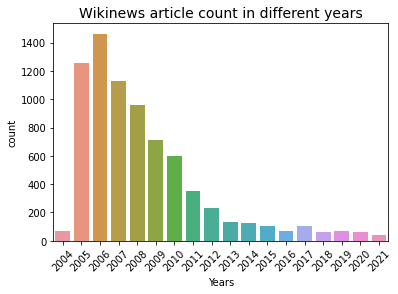

In [31]:
import pandas as pd
# Distribution over years
cur.execute("CREATE VIEW year_count as SELECT date_trunc('year', pub_date) AS year_group, count(id) as annually_count FROM wikinews.article INNER JOIN wikinews.date USING(date_id) GROUP BY year_group")
cur.execute("SELECT extract(year from year_group), annually_count from year_count")
year_count = pd.DataFrame(cur.fetchall(), columns=['years', 'count'])
year_count['years']=year_count['years'].astype('int64')

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.barplot(x="years", y='count',data=year_count)
ax.set_title('Wikinews article count in different years', fontsize = 14)
ax.set_xlabel('Years')
#plt.xticks(rotation = '30')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show();

## A view that integrates the article information from Fakenews and Wikinews

We have loaded Fakenews in M2

In [10]:
cur.execute("create VIEW all_news as ((select title,author,content,type from wikinews.aut inner join wikinews.w_by using(aut_id) inner join wikinews.article using(id) inner join wikinews.is_type using(id) inner join wikinews.type using(type_id)) union all (select title,authors,content,type from fakenews.aut inner join fakenews.w_by using(aut_id) inner join  fakenews.article using(id) inner join fakenews.is_type using(id) inner join fakenews.type using(type_id)))")
con.commit()

In [11]:
cur.execute("SELECT title,author,content,type from all_news")

In [13]:
import pandas as pd

In [14]:
all_news = pd.DataFrame(cur.fetchall(), columns=['title','author','content', 'type'])

In [3]:
all_news

,title,author,content,type
0,"""Jihad"" Jack Thomas acquitted of terrorism con...",wikinews,Melbourne man Jack Thomas has been acquitted o...,political
1,'Afghanistan is a 20-year venture' warns Canad...,wikinews,"Maj.-Gen. Andrew Leslie, one of Canada's top g...",political
2,'Twin Towers' warship set to enter New York,wikinews,A warship built with steel from the World Trad...,political
3,2006 New Zealand Maori Electoral Option,wikinews,Today marks the beginning of the 2006 Māori El...,political
4,2008 GOP convention to be in Minnesota,wikinews,The Republican National Committee Site Selecti...,political
...,...,...,...,...
481546,This Is How Much Russians Hate America…,Posted On,"In Russia, shopping malls are putting out Amer...",conspiracy
481547,Evergreen Doubles Down on Crazy,Posted On,“Arise and take our stand for freedom as in th...,unknown
481548,"Happy Birthday, Ad rem!",Posted On,Today is the anniversary of the birth of our s...,unknown
481549,"Here’s some frightening honesty, courtesy of t...","Posted On, Mark Schumacher In Lv, Morris Adams",Sovereign Man – by Simon Black\n\nA member of ...,conspiracy


In [16]:
all_news.to_csv('/Users/xiqing/Documents/all_news.csv', index=False)

In [2]:
import pandas as pd
all_news=pd.read_csv('/Users/xiqing/Documents/all_news.csv')

In [4]:
all_news.groupby('type').size().sort_values(ascending = False)

type
political     230365
fake           83141
rumor          41246
bias           40872
unknown        23791
conspiracy     20560
satire         12650
clickbait      12356
junksci         8743
unreliable      3744
hate            3074
reliable        1009
dtype: int64